# Women in Math and Public Policy Workshop
## Artificial Neural Networks for downscaling temperature data 
### Research question: Can machine learning techniques downscale climate data to individual weather observation stations?
January 22 - 25, 2019  

Project Lead: **Cecilia Bitz, UW**  
Team members: **Amanda Back (CSU), Katie Brennan (UW), Oriana Chegwidden (UW), Mimi Hughes (NOAA), Marielle Pinheiro (UC Davis), Kristin Van Abel (RAND)**  

Supported by the Institute for Pure and Applied Mathematics, The Rand Corporation, and the Luskin Center at UCLA

## Goal

Takes the first x number of PCs of temperature calculated from ERAi data and station data from specific locations throughout the west (one at a time) and attempts to downscale the ERAi information to each station. 

In [105]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import xarray as xr
from netCDF4 import Dataset
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import classification_report,confusion_matrix, mean_squared_error
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

In [7]:
def load_eofs(filename):
    '''
    Load EOFs constructed by CC located on cheyenne
    '''
    ds = Dataset(filename, 'r')
    neof = np.arange(20)
    times = np.arange(1980,2018)
    pcs = np.array(ds.variables['pc'][:])
    df = pd.DataFrame(pcs, index=times)
    return df

In [8]:
def load_temp_data(filename):
    '''
    Load temperature observation files located on Cheyenne to produce 
    '''
    square_df = pd.read_csv(filename, index_col='year')
    square_df = square_df.drop(columns=['lat', 'lon'])
    return square_df

In [9]:
def remove_climatology(square_df):
    '''
    Return a dataframe that removes the climatology 
    from the existing dataframe'''
    average_seasonal_cycle = square_df.mean(axis=0)[0:12]
    square_df = square_df - average_seasonal_cycle
    return square_df

In [10]:
def create_single_timeseries(square_df):
    '''
    Read in a data frame which is month x year and produce one
    which is a single timeseries
    '''
    df = pd.Series(square_df.values.ravel(), 
                   index=pd.date_range('1979-01', '2018-01', freq='M'))
    df = df.truncate(before='1979-10-01', after='2017-10-01')
    return df

CC did a principle components analysis (PCA) on the ERAinterim reanalysis temperature product and found the 20 modes of variability across the western US. She then created a file including the weights of each of those PCs for every month of the year for the reanalysis period of record. Let's load those into a data frame!

In [11]:
pc_file = '/gpfs/fs1/work/bitz/WPO2019/PrepareERAiT2m/T2m_ERAi_inputs_1980to2017WaterYear.csv'
features = pd.read_csv(pc_file)
features.index = pd.date_range(start='10-1979', end='10-2017', freq='M')

Let's also do a little formatting to make the data frame that houses the PCs a little neater

In [12]:
column_names = []
for i in range(1,21):
    column_names.append('pc'+str(i))
column_names.append('RegionalMean')
index = pd.date_range(start='10-01-1979', end='10-01-2017', freq='M')
features = pd.DataFrame(data=features[column_names].values, columns=column_names, index=index)

Add the observations into the same data frame

In [125]:
station_list = ['AFF', 'AKO', 'ALS', 'ASE', 'BKF', 'CEZ', 
                       'COS', 'DRO', 'PUB', 'EGE', 'FCS', 'GUC', 
                       'TAD', 'GJT', 'MTJ']
# locations with incomplete timeseries:  and LHX 'STK', HDN, LIC
targets = pd.DataFrame(columns=station_list, index=features.index)
for station in station_list:
    filename = '/glade/work/acback/WPO2019/%s.csv' % station
    targets[station] = create_single_timeseries(
                            remove_climatology(load_temp_data(filename)))

We'll divide the record into a training period and a test period. The training period (which ends at the `split_date`) will be used to train the machine learning model. That model will then be evaluated by using the data from the test period (the period after the `split_date`). 

In [126]:
split_date = '2004-10-01'

features_train = features.truncate(after=split_date)
features_test = features.truncate(before=split_date)
targets_train = targets.truncate(after=split_date)
targets_test = targets.truncate(before=split_date)

# Now let's get into the machine learning piece!
## Random forest 

First, instantiate model specifying any parameters you might be interested in.


In [127]:
rf = RandomForestRegressor(n_estimators=1000, random_state=41)

Then, train the model on your specified selection of training data

In [128]:
rf.fit(features_train.values , targets_train.values.squeeze());

Finally, try out the trained model using the data you have reserved for testing (and add it back into your original dataframe).

In [129]:
predictions = rf.predict(features_test)

How well did you do? Let's check out the R^2!

In [130]:
test_r2 = rf.score(features_test, targets_test)
train_r2 = rf.score(features_train, targets_train)
print('Training R^2 is: %s' % train_r2)
print('Test R^2 is: %s' % test_r2)

Training R^2 is: 0.8702208989706717
Test R^2 is: -0.454264575641344


In [131]:
predictions = pd.DataFrame(predictions, columns=targets_test.columns, index=targets_test.index)

# Artificial neural networks

## Data Preprocessing

Here the both the training and testing data is normalized because the neural networks can be sensitive to this type of scaling. We use built-in standardization tools to remove the mean and divide by the standard deviation. 

In [22]:
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(features_train)

# Now apply the transformations to the data, appears to subtract mean and normalize by std dev 
X_train = scaler.transform(features_train)
X_test = scaler.transform(features_test)

## 3. Training the model

Now, and instanse of the model is created. We only define the hidden_layer_sizes. You pass this function a tuple consisting of the number of neurons you want at each layer, where the nth entry in the tuple represents the number of neurons in the nth layer of the MLP model. Currently, the number of neurons are the same as the number of features in the data and the max number of iterations is 500.

In [143]:
mlp = MLPRegressor(hidden_layer_sizes=(15,15,15),max_iter=10000)

Now the model has been made so we can fit the preprocessed training data to our model. 

#### The next cell does the fit to the training data **once**. 

In [144]:
predictions_ann = pd.DataFrame(columns=station_list, index=features_test.index)
for station in station_list:
    Y_train = targets_train[station]
    Y_test = targets_test[station]
    print(station)

    mlp.fit(X_train, Y_train)
#     iters = 100
#     predictions_100 = np.zeros((iters,X_test.shape[0]))

#     for it in range(iters):
#         mlp.fit(X_train,Y_train)
#         predictions_100[it,:] = mlp.predict(X_test)
    predictions_ann[station] = mlp.predict(X_test)

AFF
AKO
ALS
ASE
BKF
CEZ
COS
DRO
PUB
EGE
FCS
GUC
TAD
GJT
MTJ


#### This next cell does the fit to the training data **iters** times. 

In [ ]:
iters = 100
predictions_100 = np.zeros((iters,X_test.shape[0]))

for it in range(iters):
    mlp.fit(X_train,Y_train)
    predictions_100[it,:] = mlp.predict(X_test)

In [ ]:
# garcin's algorithm for random forest diagnosis

## 4. Predictions and Evaluation

Now we're ready to make our predictions with the test data!

In [146]:
predictions = mlp.predict(X_test)

In [147]:
print('R^2 for testing data: = {}'.format(mlp.score(X_train,Y_train)))
print('R^2 for training data: = {}'.format(mlp.score(X_test,Y_test)))
print('Hand-calculated R^2 for predictions/station data: = {}'.format(np.corrcoef(predictions, Y_test)[0, 1]**2))

R^2 for testing data: = 0.9957501874171028
R^2 for training data: = -2.540350678100552
Hand-calculated R^2 for predictions/station data: = 5.65130725012194e-05


Calculate the mean squared error: 

In [ ]:
mean_squared_error(Y_test,predictions)

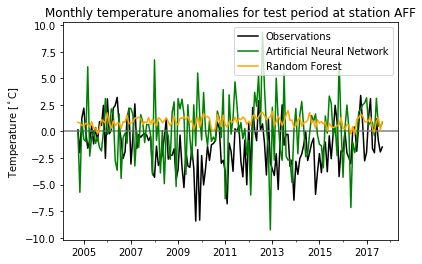

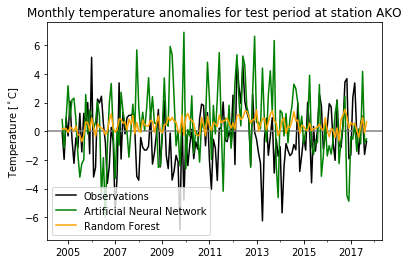

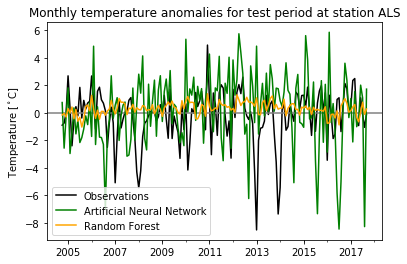

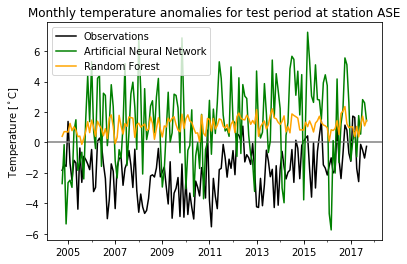

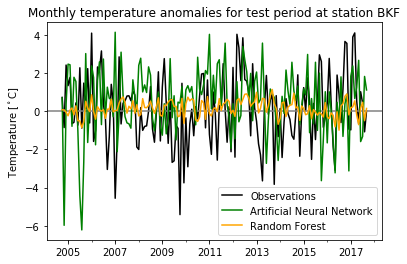

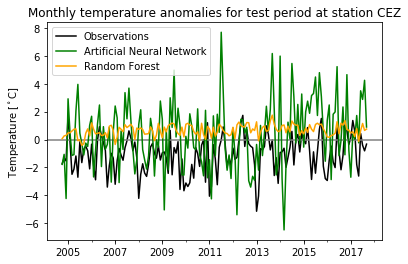

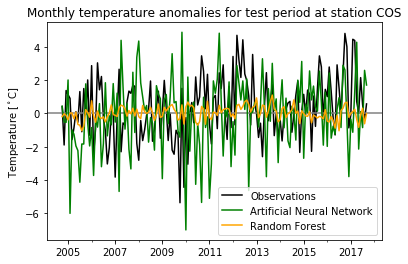

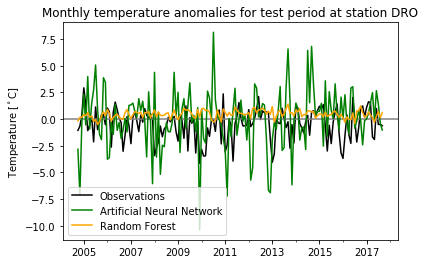

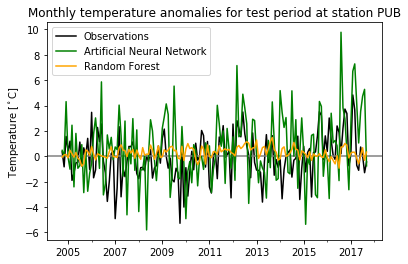

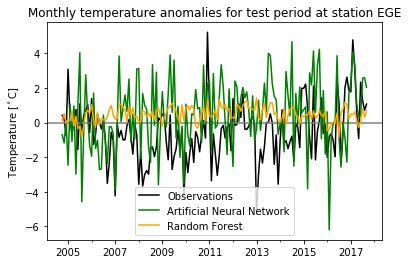

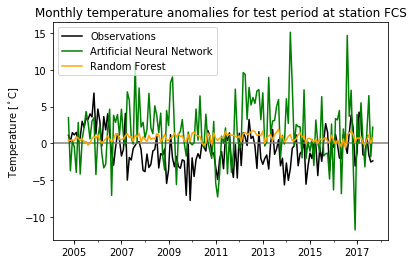

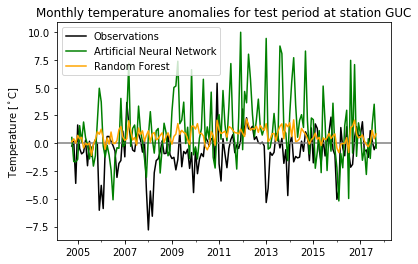

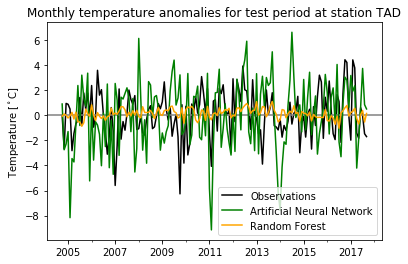

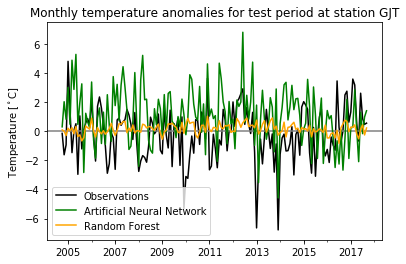

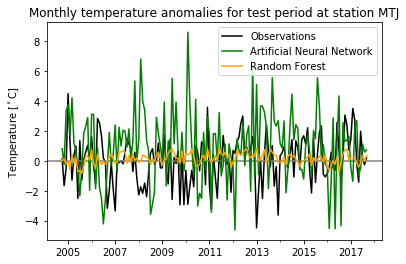

In [145]:
for station in station_list:
    plt.figure()

    targets_test[station].plot(label='Observations', color='k')
    plt.axhline(0, color='grey')

    predictions_ann[station].plot(label='Artificial Neural Network', color='green')
    predictions[station].plot(label='Random Forest', color='orange')

    plt.ylabel('Temperature [$^\circ$C]')
    plt.legend()
    plt.title('Monthly temperature anomalies for test period at station %s' % station)
    plt.savefig('comparing_methods_%s_test_period.png' % station, dpi=250)

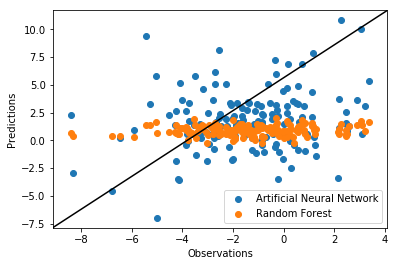

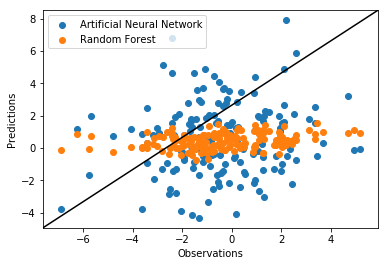

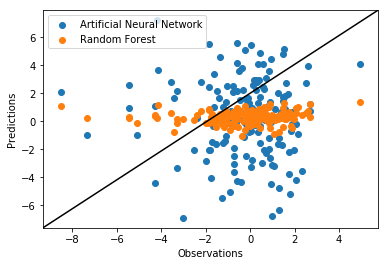

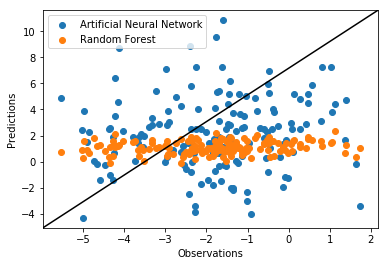

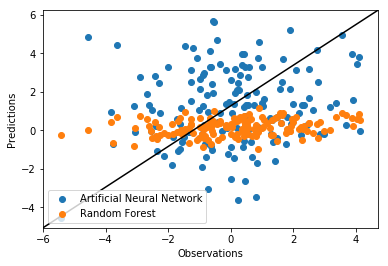

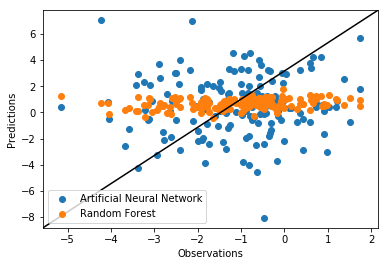

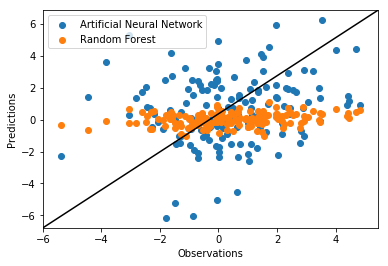

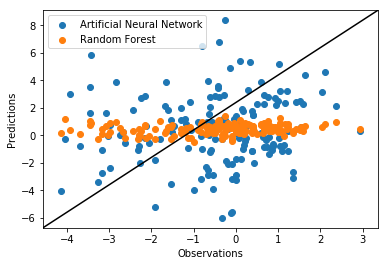

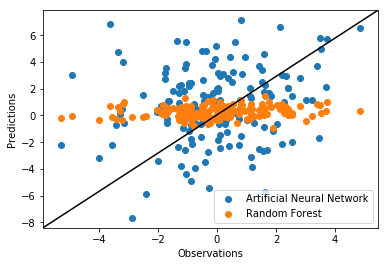

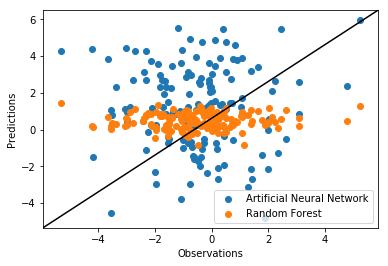

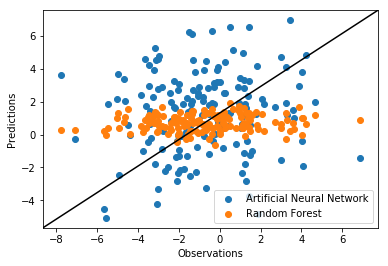

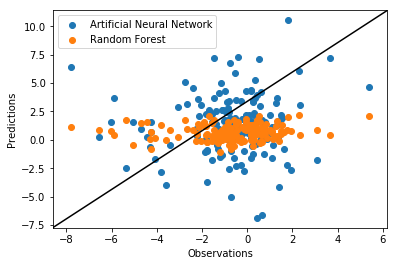

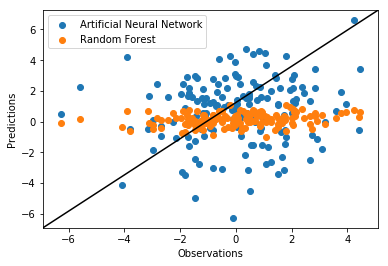

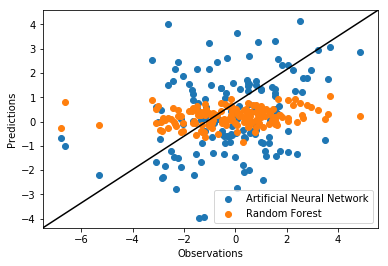

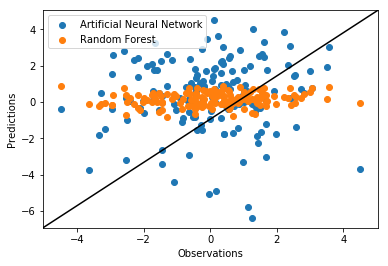

In [142]:
for station in station_list:
    fig, ax = plt.subplots()
    plt.scatter(targets_test[station], predictions_ann[station], 
                label='Artificial Neural Network')
    plt.scatter(targets_test[station], predictions[station], label='Random Forest')
    plt.legend()
    plt.xlabel('Observations')
    plt.ylabel('Predictions')
    line = mlines.Line2D([0, 1], [0, 1], color='black')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    #     targets_test[station].plot(label='Observations', color='k')
#     plt.axhline(0, color='grey')
#     predictions_ann[station].plot(label='Artificial Neural Network', color='green')
#     predictions[station].plot(label='Random Forest', color='orange')

#     plt.ylabel('Temperature [$^\circ$C]')
#     plt.legend()
#     plt.title('Monthly temperature anomalies for test period at station %s' % station)
#     plt.savefig('comparing_methods_%s_test_period.png' % station, dpi=250)

In [97]:
targets[station].shape

(456,)

In [ ]:
rf.feature_importances_

## Visualizing a Single Decision Tree

In [ ]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Pull out one tree from the forest
tree = rf.estimators_[0]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = column_names, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
graph.write_png('tree.png'); 

# Now let's make a baseline: pure interpolation